In [4]:
import numpy as np
import pandas as pd
import gym
from gym import Env
from gym.spaces import Box, Discrete, MultiDiscrete
import os
import tensorflow
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import itertools
import scipy.stats as st
import numpy as np
import mplfinance as mpf

In [5]:
with pd.ExcelFile('data.xlsx') as xls:
    RewardVector = pd.read_excel(xls, 'RewardVector')
    InputStates = pd.read_excel(xls, 'InputStates')

In [6]:

def tangency_weights(covariance_matrix, mean_vector):
    n = len(mean_vector)
    
    # Objective function to maximize (Sharpe ratio)
    def objective_function(weights):
        portfolio_return = np.dot(weights, mean_vector)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        return -portfolio_return / portfolio_std
    
    # Constraint: sum of weights equals 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1})
    
    # Bounds for each weight (-1 <= weight <= 1)
    bounds = tuple((-1, 1) for _ in range(n))
    
    # Initial guess for weights
    initial_guess = np.ones(n) / n
    
    # Optimization
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Extracting optimal weights
    optimal_weights = result.x
    
    # Calculate the mean and standard deviation of the tangency portfolio
    tangency_return = np.dot(optimal_weights, mean_vector)
    tangency_std = (np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))
    
    return {
        'weights': optimal_weights,
        'mean': tangency_return,
        'std': tangency_std,
        'maximized_value': -result.fun  # Negative because we minimized the negative of Sharpe ratio
    }

# Example usage:
# Assuming RewardVector is a DataFrame containing your data

result = tangency_weights(RewardVector.cov(), RewardVector.mean())
print("Optimal Weights:", result['weights'])
print("Tangency Portfolio Mean:", result['mean'] * 100)  # Assuming mean is annualized
print("Tangency Portfolio Standard Deviation:", result['std'])
print("Maximized Value:", result['maximized_value'])

Optimal Weights: [0.10670817 0.89329183]
Tangency Portfolio Mean: 0.006803506674029353
Tangency Portfolio Standard Deviation: 2.0039969804746802e-05
Maximized Value: 0.015197924536517766


In [7]:
Rewards = pd.DataFrame()
Rewards['R_t'] = RewardVector['Stock_1_Close']/4 + 3*RewardVector['Stock_2_Close']/4
Rewards['B_t'] = (RewardVector['Stock_1_Close']**2+3*RewardVector['Stock_2_Close']**2)/4

In [8]:
RewardVector.iloc[:500].cov()

Stock_1_Close  Stock_2_Close
Stock_1_Close       0.000083      -0.000018
Stock_2_Close      -0.000018       0.000027

In [9]:

# Assuming mu and C are already calculated as NumPy arrays
mu = np.array([0.000237, 0.000449])  # Replace with your calculated mean vector
C = np.array([[0.000083, -0.000018], [-0.000018, 0.000027]])  # Replace with your calculated covariance matrix

# Calculate mu^T C^{-1}
mu_C_inv = np.dot(mu, np.linalg.inv(C))

# Calculate mu^T C^{-1} * 1
mu_C_inv_dot_1 = np.dot(mu_C_inv, np.ones(mu.shape[0]))

# Calculate w^T
wT = mu_C_inv / mu_C_inv_dot_1

print("w^T:", wT)

import numpy as np
from scipy.optimize import minimize

# Assuming mu and C are already calculated as NumPy arrays
mu = np.array([0.000237, 0.000449])  # Replace with your calculated mean vector
C = np.array([[0.000083, -0.000018], [-0.000018, 0.000027]])  # Replace with your calculated covariance matrix

# Define the negative Sharpe ratio function (to be minimized)
def negative_sharpe_ratio(w):
    w = np.array(w)
    w_mu = np.dot(w, mu)
    w_C_w = np.dot(np.dot(w, C), w)
    sharpe_ratio = w_mu / np.sqrt(w_C_w)
    return -sharpe_ratio

# Define the constraints (sum of weights equals 1)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Define the bounds for each weight (0 <= w_i <= 1 for all i)
bounds = tuple((0, 1) for _ in range(len(mu)))

# Initial guess for the weights
initial_guess = np.ones(len(mu)) / len(mu)

# Minimize the negative Sharpe ratio (maximize the Sharpe ratio)
result = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal weight vector
optimal_weights = result.x

# Calculate the optimal Sharpe ratio
optimal_sharpe_ratio = -result.fun

print("Optimal Weights:", optimal_weights)
print("Optimal Sharpe Ratio:", optimal_sharpe_ratio)
print(np.dot(optimal_weights , mu))

print((np.dot(optimal_weights , mu))/(np.dot(np.dot(optimal_weights , C),optimal_weights)))

w^T: [0.25852465 0.74147535]
Optimal Weights: [0.25843688 0.74156312]
Optimal Sharpe Ratio: 0.10732268974028918
0.00039421138147879104
29.21823233485221


In [10]:
C = RewardVector.iloc[:500].cov()
w = pd.Series([1/4 ,3/4])  
result = np.dot(np.dot(w, C), w)
result2 = Rewards['B_t'].iloc[:500].mean() -Rewards['R_t'].iloc[:500].mean()**2
print('Variance Real',result )
print('Variance est',result2 )
print('Difference',result/ result2 )

Variance Real 1.4061225855118099e-05
Variance est 4.12418277501882e-05
Difference 0.3409457490654966


In [11]:
Rewards['R_t'].iloc[:500].mean()/(Rewards['B_t'].iloc[:500].mean() -Rewards['R_t'].iloc[:500].mean()**2)

9.607189172289731

In [12]:
mu = RewardVector.iloc[:500].mean()
w = pd.Series([1/4 ,3/4])  
np.dot(np.transpose(w), mu)/result

28.178058235429603

In [13]:
mu = RewardVector.iloc[:500].mean()
w = pd.Series([1/4 ,3/4])  
result = np.dot(np.transpose(w), mu)
result2 = Rewards['R_t'].iloc[:500].mean()
print('mu Real',result )
print('mu est',result2 )
print('Difference',result/ result2 )

mu Real 0.0003962180410070462
mu est 0.00039621804100704617
Difference 1.0000000000000002


In [14]:
mu

Stock_1_Close    0.000237
Stock_2_Close    0.000449
dtype: float64

In [15]:
Rewards = pd.DataFrame()
Rewards['R_t'] = RewardVector['Stock_1_Close']/4 + 3*RewardVector['Stock_2_Close']/4
Rewards['B_t'] = (RewardVector['Stock_1_Close']**2+3*RewardVector['Stock_2_Close']**2)/4

c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\frame.py:11198: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


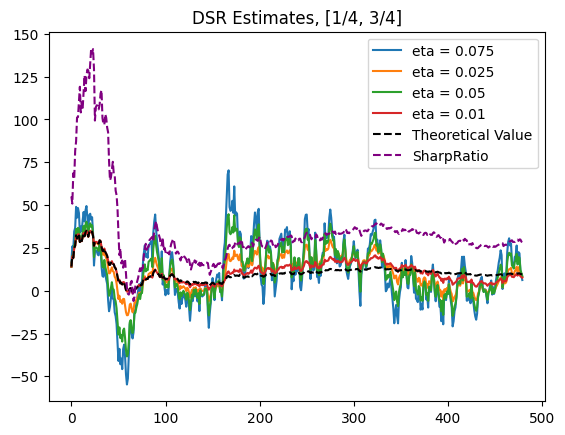

In [215]:
etas = [0.075 , 0.025 ,0.05 , 0.01]
for eta in etas:
    At = 0
    Bt = 0
    dsr = []
    
    for i in range(500):
        if eta < 1/(i+1):
            changeA = Rewards['R_t'].iloc[:i+1].mean()
            changeB = Rewards['B_t'].iloc[:i+1].mean()
        else:
            changeA = At + eta * (Rewards['R_t'].iloc[i] - At)
            changeB = Bt + eta * (Rewards['B_t'].iloc[i] - Bt)

        if changeB != changeA**2:
            dsr.append(changeA/ (changeB - changeA**2))
        
        At = changeA
    
        Bt = changeB

    plt.plot(dsr[20:], label=f'eta = {eta}')
dsrest = []
for i in range(500):
    dsrest.append(Rewards['R_t'].iloc[:i+1].mean()/ ((Rewards['B_t'].iloc[:i+1].mean()- Rewards['R_t'].iloc[:i+1].mean()**2)))
plt.plot(dsrest[20:], label='Theoretical Value', linestyle='--', color='black')
sharpratio = []
w = pd.Series([1/4 ,3/4])  
for i in range(500):
    C = RewardVector.iloc[:i].cov()
    mu = RewardVector.iloc[:i].mean()
    sharpratio.append( np.dot(np.transpose(w), mu)/ np.dot(np.dot(w, C), w))
plt.plot(sharpratio[20:], label='SharpRatio', linestyle='--', color='purple')
plt.title('DSR Estimates, [1/4, 3/4]')
plt.legend()
plt.savefig('DSRQuarters.png')

plt.show()

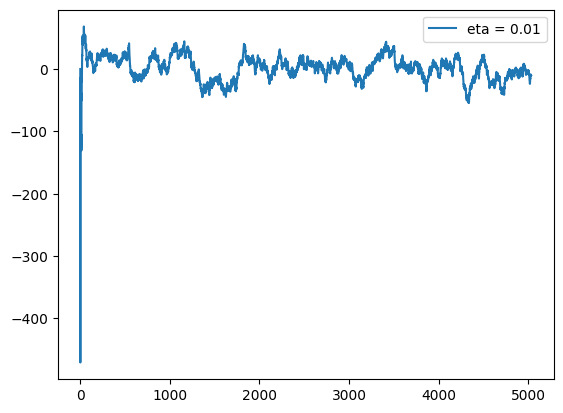

In [121]:
class DSRCalculator:
    def __init__(self, eta):
        self.eta = eta
        self.count = 0
        self.last_vt = 0
        self.last_wt = 0
        self.last_sr = 0

    def calculate_dsr(self, rt):
        if self.count < 1 / self.eta:
            changeA = (self.count * self.last_vt + rt) / (self.count + 1)
            changeB = (self.count * self.last_wt + rt ** 2) / (self.count + 1)
        else:
            changeA = self.last_vt + self.eta * (rt - self.last_vt)
            changeB = self.last_wt + self.eta * (rt ** 2 - self.last_wt)
        self.last_wt = changeB
        self.last_vt = changeA
        if self.last_wt - self.last_vt ** 2 != 0:
            self.last_sr = self.last_vt / (self.last_wt - self.last_vt ** 2)
        self.count += 1

        return self.last_sr


# Example usage:
etas = [0.01]
for eta in etas:
    calculator = DSRCalculator(eta)
    dsr = []
    for rt in Rewards['R_t']:
        dsr.append(calculator.calculate_dsr(rt))
    plt.plot(dsr, label=f'eta = {eta}')
plt.legend()
plt.show()


In [ ]:
def calculate_dsr(self, rt):
        if self.count< 1/self.eta:
            changeA = (self.count*self.last_vt+ rt)/(self.count+1)
            changeB = (self.count*self.last_wt+ rt**2)/(self.count+1)
        else:
            changeA = self.last_vt + self.eta * (rt - self.last_vt)
            changeB = self.last_wt + self.eta * (rt**2 - self.last_wt)
        self.last_wt = changeB
        self.last_vt = changeA
        if self.last_wt - self.last_vt**2 != 0:
            self.last_sr = self.last_vt/ ((self.last_wt - self.last_vt**2))
        self.count+=1

        return self.last_sr

In [16]:
class ReplayBuffer():
    def __init__(self, max_size , input_shape, n_actions, discrete= True):
        self.mem_size = max_size
        self.input_spahe =input_shape
        self.dis = discrete
        self.mem_counter = 0
        self.state_mem =np.zeros((self.mem_size , input_shape))
        self.new_state_mem = np.zeros((self.mem_size , input_shape))

        dtype = np.int8 if self.dis else np.float32
        self.action_mem = np.zeros((self.mem_size , n_actions), dtype=dtype)
        self.reward_mem = np.zeros((self.mem_size))
        self.terminal_mem = np.zeros(self.mem_size, dtype=np.float32) #he has this as float???

    def Store_transition(self, state, action , reward , next_state , done):
        index = self.mem_counter%self.mem_size
        self.state_mem[index] = state
        self.new_state_mem[index] = next_state
        self.action_mem[index] = action
        self.reward_mem[index] = reward
        self.terminal_mem[index] = 1- int(done)

        if self.dis:
            actions = np.zeros(self.action_mem.shape[1])
            actions[action] =1.0
            self.action_mem[index] = actions
        else:
            self.action_mem[index] = action
        self.mem_counter+=1

    def Sample_buffer(self, batch_size):
        Max_mem = min(self.mem_counter , batch_size)
        batch = np.random.choice(Max_mem, batch_size , replace= False)
        states = self.state_mem[batch]
        states_ = self.new_state_mem[batch]
        action = self.action_mem[batch]
        reward = self.reward_mem[batch]
        EpisodeEnds = self.terminal_mem[batch]

        return states, action, reward,states_, EpisodeEnds

In [17]:
class ContextualBandit(object):
    
    def __init__(self, state_dim, action_dim,steps, transform = None, gamma=0.9, alpha=0.1, epsilon=1, decay=0.99999,
                  decaya=0.9 , cf1 = 64 , cf2 = 64, batch_size = 5000, max_mem = 100000, model_file = 'dqn_model.h5' , tau =0.05 , eta = 1e-2 ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.maxmem = max_mem
        self.steps = steps
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.model_file = model_file
        self.eps = epsilon
        self.decay = decay
        self.decaya = decaya
        self.actions = self.generate_grid(action_dim-1, self.steps, transform)
        self.action_dim = len(self.actions)*2
        self.tau = tau
        self.cf1 = cf1
        self.cf2 = cf2
        self.last_vt = 0
        self.last_wt = 0
        self.eta = eta
        self.last_sr = 0
        self.count = 0
        self.model = self.build_model()  # Initialize model after num_tilings
        self.target = self.build_model()
        self.Memory = ReplayBuffer(max_mem, state_dim, self.action_dim , discrete= True)
        self.Update_NN_Parameters(tau=1)
    
    def generate_grid(self, n, m, offset=None):
        # Generate all possible combinations of bin sizes
        points = []
        for combination in itertools.product(*[range(-m, m + 1) for _ in range(n)]):
            if all(abs(x) <= m for x in combination) and all(-1 <= x / m <= 1 for x in combination):
                points.append(combination)

        points = np.array(points) / m
        
        if offset is not None:
            points += np.array(offset)
        
        # Filter out points where the sum of absolute values is greater than 1
        points = [point for point in points if sum(abs(x) for x in point) <= 1]
        
        return np.array(points)
        
    

    def build_model(self):
        model = Sequential([
            LSTM(self.cf1, activation='relu', input_shape=(None, self.state_dim)),
            Dense(self.action_dim, activation='softmax')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
        return model

        
    def Remember(self, state, action, reward, next_state, done):
        
        self.Memory.Store_transition(state,action, reward, next_state, done)
    
    def select_action(self, state, bool=True):
        
        if max(self.eps, 0.01) > np.random.random() and bool:
            self.eps *= self.decay
            return np.random.randint(self.action_dim)
        else: 
            
            action_probabilities = self.model.predict(state)
            action_index = np.argmax(action_probabilities)
            return action_index
        
    def Update_NN_Parameters(self, tau=None):
        if tau is None:
            tau = self.tau
            
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target.get_weights()

        updated_actor_target_weights = []

        for actor_weight, target_weight in zip(actor_weights, actor_target_weights):
            updated_weight = actor_weight * tau + target_weight * (1 - tau)
            updated_actor_target_weights.append(updated_weight)

        self.target.set_weights(updated_actor_target_weights)


    def learn(self):
        if self.Memory.mem_counter < self.batch_size:
            return 0, 0
            
        # Sample minibatch from replay buffer
        state, action, reward, new_state, done = self.Memory.Sample_buffer(self.batch_size)
        state = state.reshape(self.batch_size, 1, self.state_dim)
        new_state = new_state.reshape(self.batch_size, 1, self.state_dim)
        # Compute Q-values for current and next states
        q_eval = self.model.predict(state)
        q_next = self.model.predict(new_state)
        q_target = self.target.predict(state)
        
        # Compute target Q-values using the target network
        q_next_target = self.target.predict(new_state)
        
        # Compute action indices
        actionind = np.argmax(action, axis=1)
        
        # Define batch indices
        batchindex = np.arange(self.batch_size)
        
        # Update target Q-values less frequently
        if self.count > 450 == 0:
            self.Update_NN_Parameters()
        
        # Update Q-network
        q_target[batchindex, actionind] = reward + self.gamma * np.max(q_next_target, axis=1) * done
        
        # Train the main Q-network
        _ = self.model.fit(state, q_target, verbose=0)
        
        
        
        # Compute Q-values after update
        q_eval_after_update = self.model.predict(state)
        self.alpha *= self.decaya
        
        return q_eval, q_eval_after_update


    
    def save_model(self):
        self.model.save(self.model_file)

    def _tiny(self):
        return np.finfo('float64').eps
    
    
    def calculate_dsr(self, rt):
        if self.count < 1 / self.eta:
            changeA = (self.count * self.last_vt + rt) / (self.count + 1)
            changeB = (self.count * self.last_wt + rt ** 2) / (self.count + 1)
        else:
            changeA = self.last_vt + self.eta * (rt - self.last_vt)
            changeB = self.last_wt + self.eta * (rt ** 2 - self.last_wt)
        self.last_wt = changeB
        self.last_vt = changeA
        if self.last_wt - self.last_vt ** 2 != 0:
            self.last_sr = self.last_vt / (self.last_wt - self.last_vt ** 2)
        self.count += 1

        return self.last_sr
    
    def reset(self):
        self.count = 0
        self.last_sr = 0
        self. last_vt = 0
        self.last_wt = 0

    def GetReward(self, action, rewards):
        act = self.actions[action%(len(self.actions))]

        if np.sum(np.abs(act)) >1:
            return - 10000000000000
        else:
            if action < len(self.actions): #the last one is a buy
                acti = np.append(act , 1-np.sum(np.abs(act)))
            else: # For a sell of the last.
                acti = np.append(act , np.sum(np.abs(act))-1)
        
        reward = np.array(rewards)
        Rt = np.dot(reward,np.array(acti))
        reward = self.calculate_dsr(Rt)
        return reward

In [18]:
# Initialize lists to store evaluation results
eval = []
# Concatenate the two DataFrames along axis 1 (columns)
df = InputStates

# Optional: Reset the index of the concatenated DataFrame
df.reset_index(drop=True, inplace=True)

state_dim = df.shape[1] + 2
action_dim = RewardVector.shape[1]
agent = ContextualBandit(state_dim, action_dim, steps=4, decay=0.99999, batch_size=15000, eta=0.01)
agent.actions



model_path = "Sharp2.pkl"

save_interval = 500  # Save the model every 1000 iterations

for j in range(200):
    a = np.random.randint(10 , len(df)- 2000)
    
    agent.reset()

    for i in range(500):
        state = df.iloc[i + a]
        state_array = state.values.reshape(1, -1)
        result = np.hstack((state_array, np.array([[agent.last_vt, agent.last_wt]]).reshape(1, -1)))[0]
        result = result.reshape(1, 1, df.shape[1]+2)
        
        action = agent.select_action(result, bool=True)
        reward = agent.GetReward(action, RewardVector.iloc[i + a])
        

        next_state = df.iloc[i + a + 1]
        next_state_array = next_state.values.reshape(1, -1)
        result2 = np.hstack((next_state_array, np.array([[agent.last_vt, agent.last_wt]]).reshape(1, -1)))[0]
        result2 = result2.reshape(1, 1, df.shape[1]+2)
        done = False

        if i % 50 == 0 or agent.count == 500:
            agent.Remember(result, action, reward, result2, done)
            e1, e2 = agent.learn()

            if isinstance(e1, np.ndarray) and isinstance(e2, np.ndarray):
                eval.append(sum(sum(abs(e1-e2))))
            

        agent.Remember(result, action, reward, result2, done)

        if i % save_interval == 0:
            # Save the model periodically
            with open(model_path, 'wb') as f:
                pickle.dump(agent, f)
            print(f"Model saved at iteration {i} as {model_path}")

plt.plot(eval)
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Reward Trend over Training')
plt.show()



Model saved at iteration 0 as Sharp2.pkl
1/1 [==============================] - 0s 19ms/step
Model saved at iteration 0 as Sharp2.pkl
1/1 [==============================] - 0s 19ms/step
Model saved at iteration 0 as Sharp2.pkl
1/1 [==============================] - 0s 22ms/step
Model saved at iteration 0 as Sharp2.pkl
1/1 [==============================] - 0s 19ms/step
Model saved at iteration 0 as Sharp2.pkl
1/1 [==============================] - 0s 20ms/step
Model saved at iteration 0 as Sharp2.pkl
1/1 [==============================] - 0s 18ms/step
Model saved at iteration 0 as Sharp2.pkl
1/1 [==============================] - 0s 19ms/step
Model saved at iteration 0 as Sharp2.pkl
1/1 [==============================] - 0s 20ms/step
Model saved at iteration 0 as Sharp2.pkl
1/1 [==============================] - 0s 22ms/step
Model saved at iteration 0 as Sharp2.pkl
1/1 [==============================] - 0s 18ms/step
Model saved at iteration 0 as Sharp2.pkl
1/1 [=======================

KeyboardInterrupt: 

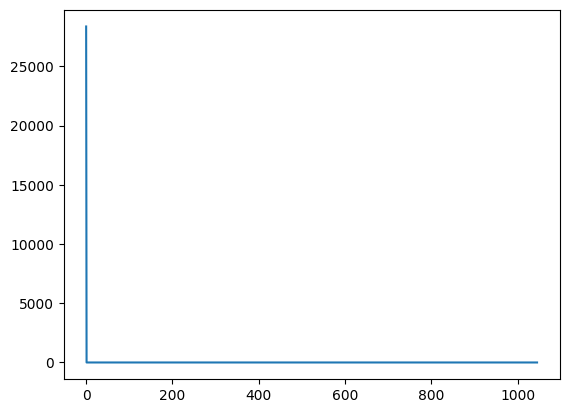

In [21]:
plt.plot(eval)

In [20]:
# Initialize lists to store actions and rewards
test_actions = []
test_rewards = []
# Testing loop
agent.reset()
a=10
for i in range(len(df)-500):

    state = df.iloc[i + a]
    state_array = state.values.reshape(1, -1)
    result = np.hstack((state_array, np.array([[agent.last_vt, agent.last_wt]]).reshape(1, -1)))[0]
    result = result.reshape(1, 1, df.shape[1]+2)
    action = agent.select_action(result, bool=False)
    test_actions.append(action)
    reward = agent.GetReward(action, RewardVector.iloc[i + a])
    test_rewards. append(reward)
    

    next_state = df.iloc[i + a + 1]
    next_state_array = next_state.values.reshape(1, -1)
    result2 = np.hstack((next_state_array, np.array([[agent.last_vt, agent.last_wt]]).reshape(1, -1)))[0]
    result2 = result2.reshape(1, 1, df.shape[1]+2)
    done = False

print("Actions taken during testing:", test_actions)
print("Rewards obtained during testing:", test_rewards)
plt.plot(test_rewards)

1/1 [==============================] - 0s 19ms/step


KeyboardInterrupt: 

In [44]:
11 % len(agent.actions)

2

In [40]:
agent.actions

array([[-1.  ],
       [-0.75],
       [-0.5 ],
       [-0.25],
       [ 0.  ],
       [ 0.25],
       [ 0.5 ],
       [ 0.75],
       [ 1.  ]])

In [29]:
model_path = "Sharp2.pkl"

save_interval = 500  # Save the model every 1000 iterations

for j in range(200):
    a = np.random.randint(10 , len(df)- 2000)
    
    agent.reset()

    for i in range(10, 510):
        state = df.iloc[i + a]
        state_array = state.values.reshape(1, -1)
        result = np.hstack((state_array, np.array([[agent.last_vt, agent.last_wt]]).reshape(1, -1)))[0]
        result = result.reshape(1, 1, df.shape[1]+2)
        
        action = agent.select_action(result, bool=True)
        reward = agent.GetReward(action, RewardVector.iloc[i + a])
        

        next_state = df.iloc[i + a + 1]
        next_state_array = next_state.values.reshape(1, -1)
        result2 = np.hstack((next_state_array, np.array([[agent.last_vt, agent.last_wt]]).reshape(1, -1)))[0]
        result2 = result2.reshape(1, 1, df.shape[1]+2)
        done = False

        if i % 50 == 0:
            agent.Remember(result, action, reward, result2, done)
            e1, e2 = agent.learn()
            if isinstance(e1, np.ndarray) and isinstance(e2, np.ndarray):
                eval.append(sum(sum(abs(e1-e2))))

        agent.Remember(result, action, reward, result2, done)

        if i % save_interval == 0:
            # Save the model periodically
            with open(model_path, 'wb') as f:
                pickle.dump(agent, f)
            print(f"Model saved at iteration {i} as {model_path}")




157/157 [==============================] - 0s 1ms/step
Model saved at iteration 500 as Sharp2.pkl
1/1 [==============================] - 0s 24ms/step


157/157 [==============================] - 0s 967us/step
Model saved at iteration 500 as Sharp2.pkl
157/157 [==============================] - 0s 953us/step
Model saved at iteration 500 as Sharp2.pkl
157/157 [==============================] - 0s 1ms/step
Model saved at iteration 500 as Sharp2.pkl
157/157 [==============================] - 0s 1ms/step
Model saved at iteration 500 as Sharp2.pkl
157/157 [==============================] - 0s 2ms/step
Model saved at iteration 500 as Sharp2.pkl
157/157 [==============================] - 0s 1ms/step
Model saved at iteration 500 as Sharp2.pkl
157/157 [==============================] - 0s 953us/step
Model saved at iteration 500 as Sharp2.pkl
157/157 [==============================] - 0s 980us/step
Model saved at iteration 500 as Sharp2.pkl
157/157 [==============================] - 0s 1ms/step
Model saved at iteration 500 as Sharp2.pkl
157/157 [==============================] - 0s 1ms/step
Model saved at iteration 500 as Sharp2.pkl
157/157 [===

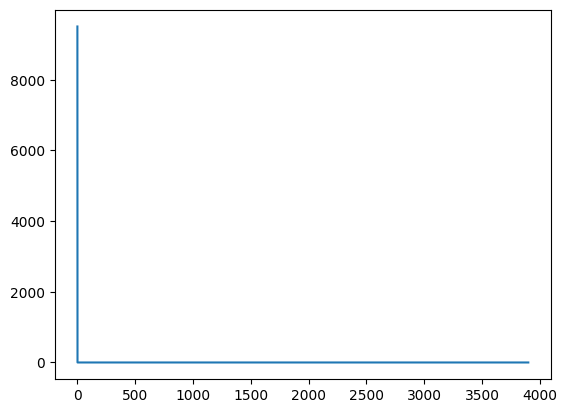

In [30]:
plt.plot(eval)


1/1 [==============================] - 0s 19ms/step
Actions taken during testing: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

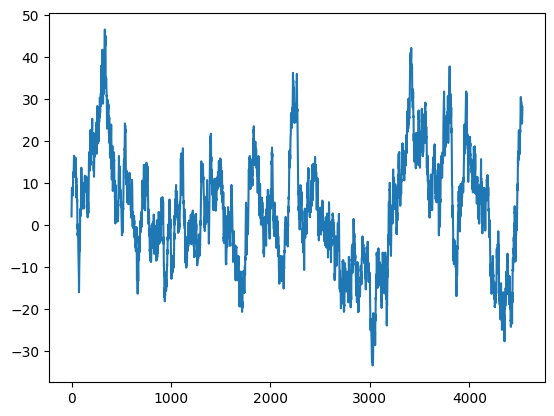

In [31]:
# Initialize lists to store actions and rewards
test_actions = []
test_rewards = []
# Testing loop
rt = np.array([0])
rt2 = np.array([0])
a=10
for i in range(len(df)-500):

    state = df.iloc[i + a]
    state_array = state.values.reshape(1, -1)
    result = np.hstack((state_array, np.array([[agent.last_vt, agent.last_wt]]).reshape(1, -1)))[0]
    result = result.reshape(1, 1, df.shape[1]+2)
    action = agent.select_action(result, bool=False)
    test_actions.append(action)
    reward = agent.GetReward(action, RewardVector.iloc[i + a])
    test_rewards. append(reward)
    

    next_state = df.iloc[i + a + 1]
    next_state_array = next_state.values.reshape(1, -1)
    result2 = np.hstack((next_state_array, np.array([[agent.last_vt, agent.last_wt]]).reshape(1, -1)))[0]
    result2 = result2.reshape(1, 1, df.shape[1]+2)
    done = False

print("Actions taken during testing:", test_actions)
print("Rewards obtained during testing:", test_rewards)
plt.plot(test_rewards)

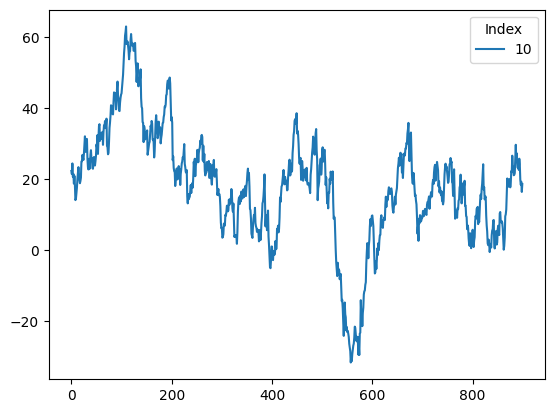

In [35]:
# Calculate average values for each sublist
# Concatenate the two DataFrames along axis 1 (columns)
df = InputStates

# Optional: Reset the index of the concatenated DataFrame
df.reset_index(drop=True, inplace=True)

state_dim = df.shape[1] + 2
action_dim = RewardVector.shape[1]
agent = ContextualBandit(state_dim, action_dim, steps=8, decay=0.99999, batch_size=5000, eta=0.01)
agent.actions

best = []
for h in range(2500):
    a = np.random.randint(10, len(df) - 1100)
    Nested_Rewards = []
    for j in range(agent.action_dim):
        avreward = []
        agent.reset
        for i in range(1000):
            reward = agent.GetReward(j, RewardVector.iloc[i + a])
            avreward.append(reward)
        Nested_Rewards.append(avreward)
    average_values = [(i, sum(sublist) / len(sublist)) for i, sublist in enumerate(Nested_Rewards)]

# Sort the sublists based on average values and select the top 5
    top_5_sublists = sorted(average_values, key=lambda x: x[1], reverse=True)[:1]
    best.append(top_5_sublists)
# Plot the top 5 sublists excluding the first 50 points
for i, _ in top_5_sublists:
    sublist = Nested_Rewards[i]
    if len(sublist) > 50:  # Check if sublist has at least 50 points
        plt.plot(sublist[100:], label=str(i))  # Plot sublist excluding the first 50 points

# Add legend
plt.legend(title="Index")

# Show plot
plt.show()



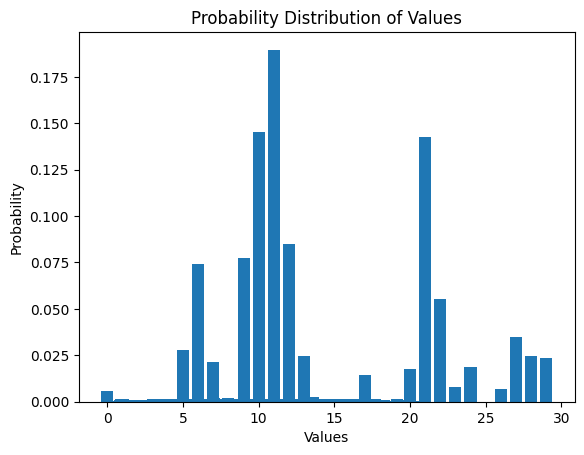

In [36]:
# Count the frequency of each value
unique_values, value_counts = np.unique(best, return_counts=True)

# Calculate the probability
total_values = len(best)
probabilities = value_counts / total_values

# Plot the probability
plt.bar(unique_values, probabilities)
plt.xlabel('Values')
plt.ylabel('Probability')
plt.title('Probability Distribution of Values')
plt.show()

In [34]:
agent.actions[10]

array([0.25])

In [116]:

def tangency_weights(covariance_matrix, mean_vector):
    n = len(mean_vector)
    
    # Objective function to maximize (Sharpe ratio)
    def objective_function(weights):
        portfolio_return = np.dot(weights, mean_vector)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        return -portfolio_return / portfolio_std
    
    # Constraint: sum of weights equals 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1})
    
    # Bounds for each weight (-1 <= weight <= 1)
    bounds = tuple((-1, 1) for _ in range(n))
    
    # Initial guess for weights
    initial_guess = np.ones(n) / n
    
    # Optimization
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Extracting optimal weights
    optimal_weights = result.x
    
    # Calculate the mean and standard deviation of the tangency portfolio
    tangency_return = np.dot(optimal_weights, mean_vector)
    tangency_std = np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))
    
    return {
        'weights': optimal_weights,
        'mean': tangency_return,
        'std': tangency_std,
        'maximized_value': -result.fun  # Negative because we minimized the negative of Sharpe ratio
    }

# Example usage:
# Assuming RewardVector is a DataFrame containing your data

result = tangency_weights(RewardVector.cov(), RewardVector.mean())
print("Optimal Weights:", result['weights'])
print("Tangency Portfolio Mean:", result['mean'] * 100)  # Assuming mean is annualized
print("Tangency Portfolio Standard Deviation:", result['std'])
print("Maximized Value:", result['maximized_value'])

Optimal Weights: [0.10670817 0.89329183]
Tangency Portfolio Mean: 0.006803506674029353
Tangency Portfolio Standard Deviation: 0.0044766024845575465
Maximized Value: 0.015197924536517766


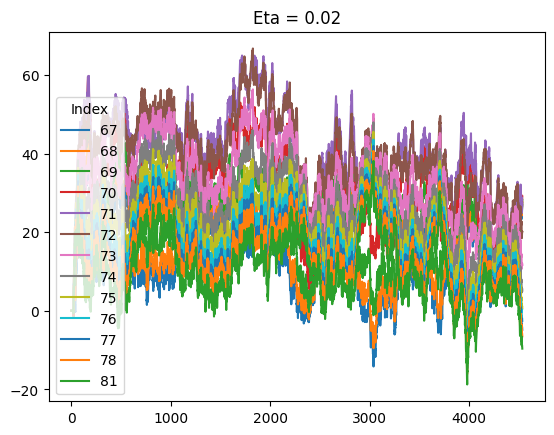

In [109]:
# Plot each sublist if it has a value over 2500
for i, sublist in enumerate(Nested_Rewards):
    if any(value > 40 for value in sublist) or i ==81:
        plt.plot(sublist, label=str(i))  # Set the legend as the index of the sublist

# Add legend
plt.legend(title="Index")
plt.title('Eta = 0.02')
# Show plot
plt.show()

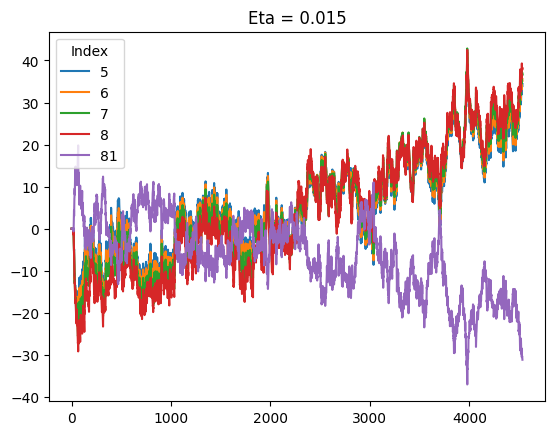

In [58]:
# Plot each sublist if it has a value over 2500
for i, sublist in enumerate(Nested_Rewards):
    if any(value > 40 for value in sublist) or i ==81:
        plt.plot(sublist, label=str(i))  # Set the legend as the index of the sublist

# Add legend
plt.legend(title="Index")
plt.title('Eta = 0.015')
# Show plot
plt.show()

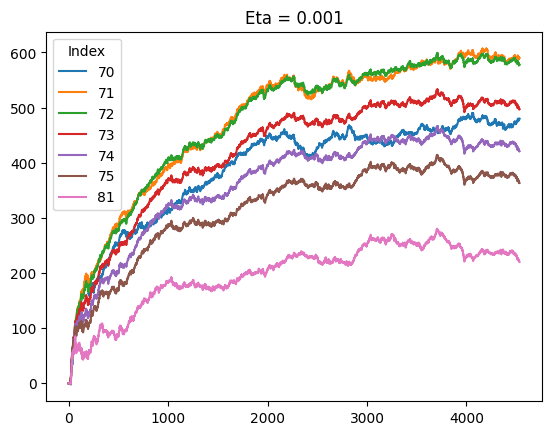

In [54]:
# Plot each sublist if it has a value over 2500
for i, sublist in enumerate(Nested_Rewards):
    if any(value > 400 for value in sublist) or i ==81:
        plt.plot(sublist, label=str(i))  # Set the legend as the index of the sublist

# Add legend
plt.legend(title="Index")
plt.title('Eta = 0.001')
# Show plot
plt.show()

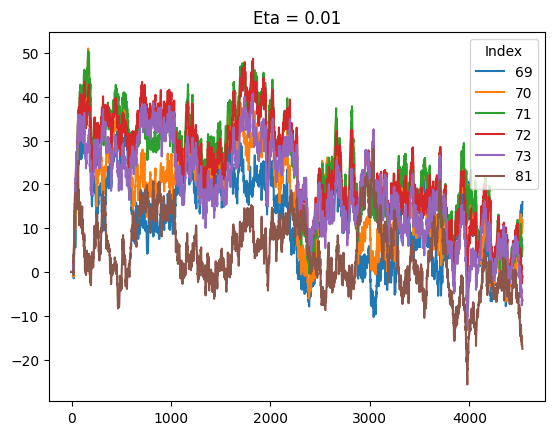

In [51]:
# Plot each sublist if it has a value over 2500
for i, sublist in enumerate(Nested_Rewards):
    if any(value > 40 for value in sublist) or i ==81:
        plt.plot(sublist, label=str(i))  # Set the legend as the index of the sublist

# Add legend
plt.legend(title="Index")
plt.title('Eta = 0.01')
# Show plot
plt.show()

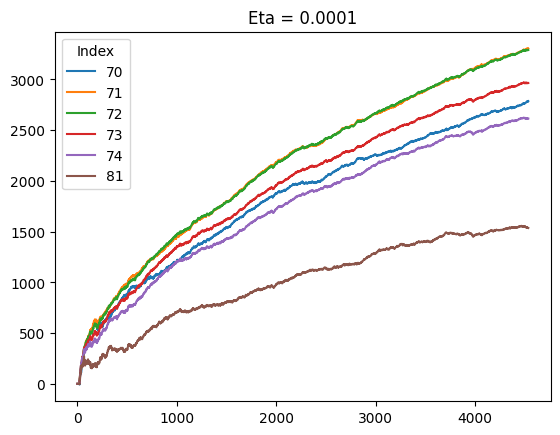

In [46]:
# Plot each sublist if it has a value over 2500
for i, sublist in enumerate(Nested_Rewards):
    if any(value > 2500 for value in sublist) or i ==81:
        plt.plot(sublist, label=str(i))  # Set the legend as the index of the sublist

# Add legend
plt.legend(title="Index")
plt.title('Eta = 0.0001')
# Show plot
plt.show()

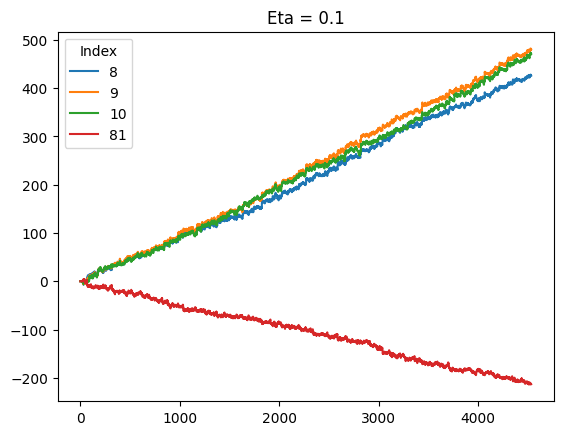

In [43]:
# Plot each sublist if it has a value over 2500
for i, sublist in enumerate(Nested_Rewards):
    if any(value > 400 for value in sublist) or i ==81:
        plt.plot(sublist, label=str(i))  # Set the legend as the index of the sublist

# Add legend
plt.legend(title="Index")
plt.title('Eta = 0.1')
# Show plot
plt.show()

In [89]:
class ContextualBandit(object):
    
    def __init__(self, state_dim, action_dim,steps, transform = None, gamma=0.9, alpha=0.0001, epsilon=1, decay=0.99999,
                  decaya=0.999 , cf1 = 64 , cf2 = 64, batch_size = 5000, max_mem = 100000, model_file = 'dqn_model.h5' , tau =0.05 , eta = 1e-2 ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.maxmem = max_mem
        self.steps = steps
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.model_file = model_file
        self.eps = epsilon
        self.decay = decay
        self.decaya = decaya
        self.actions = self.generate_grid(action_dim-1, self.steps, transform)
        self.action_dim = len(self.actions)*2
        self.tau = tau
        self.cf1 = cf1
        self.cf2 = cf2
        self.last_vt = 0
        self.last_wt = 0
        self.eta = eta
        self.last_sr = 0
        self.count = 0
        self.model = self.build_model()  # Initialize model after num_tilings
        self.target = self.build_model()
        self.Memory = ReplayBuffer(max_mem, state_dim, self.action_dim , discrete= True)
        self.Update_NN_Parameters(tau=1)
        
    
    def generate_grid(self, n, m, offset=None):
        # Generate all possible combinations of bin sizes
        points = []
        for combination in itertools.product(*[range(-m, m + 1) for _ in range(n)]):
            if all(abs(x) <= m for x in combination) and all(-1 <= x / m <= 1 for x in combination):
                points.append(combination)

        points = np.array(points) / m
        
        if offset is not None:
            points += np.array(offset)
        
        # Filter out points where the sum of absolute values is greater than 1
        points = [point for point in points if sum(abs(x) for x in point) <= 1]
        
        return np.array(points)
        
    

    def build_model(self):
        model = Sequential([
            LSTM(self.cf1, activation='relu', input_shape=(None, self.state_dim)),
            Dense(self.action_dim, activation='softmax')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
        return model

        
    def Remember(self, state, action, reward, next_state, done):
        
        self.Memory.Store_transition(state,action, reward, next_state, done)
    
    def select_action(self, state, bool=True):
        
        if max(self.eps, 0.01) > np.random.random() and bool:
            self.eps *= self.decay
            return np.random.randint(self.action_dim)
        else: 
            action_probabilities = self.model.predict(state)
            action_index = np.argmax(action_probabilities)
            return action_index
        
    def Update_NN_Parameters(self, tau=None):
        if tau is None:
            tau = self.tau
            
        actor_weights = self.model.weights
        actor_target_weights = self.target.weights

        for i, weight in enumerate(actor_weights):
            actor_target_weights[i] = weight * tau + actor_target_weights[i] * (1 - tau)
        
        self.target.set_weights(actor_target_weights)

    def learn(self):
        if self.Memory.mem_counter < self.batch_size:
            return 0, 0
            
        # Sample minibatch from replay buffer
        state, action, reward, new_state, done = self.Memory.Sample_buffer(self.batch_size)
        state = state.reshape(self.batch_size, 1, self.state_dim)
        new_state = new_state.reshape(self.batch_size, 1, self.state_dim)
        # Compute Q-values for current and next states
        q_eval = self.model.predict(state)
        q_next = self.model.predict(new_state)
        q_target = self.target.predict(state)
        
        # Compute target Q-values using the target network
        q_next_target = self.target.predict(new_state)
        
        # Compute action indices
        actionind = np.argmax(action, axis=1)
        
        # Update target Q-values
        batchindex = np.arange(self.batch_size, dtype=np.int32)
        q_target[batchindex, actionind] = reward + self.gamma * np.max(q_next_target, axis=1) * done
        
        # Train the main Q-network
        _ = self.model.fit(state, q_target, verbose=0)
        
        # Update target network parameters
        self.Update_NN_Parameters()
        
        # Compute Q-values after update
        q_eval_after_update = self.model.predict(state)
        
        return q_eval, q_eval_after_update

    
    def save_model(self):
        self.model.save(self.model_file)

    def _tiny(self):
        return np.finfo('float64').eps
    
    def calculate_dsr(self, rt):
        
        #delta_vt = rt - self.last_vt
        #delta_wt = rt**2 - self.last_wt
        #change = (self.last_wt * delta_vt - 0.5 * self.last_vt * delta_wt) / ((self.last_wt - self.last_vt**2)**(3/2) + self._tiny())
        vt = (self.last_vt * self.count + rt )/(self.count+1)
        wt = (self.last_wt * self.count + rt**2 )/(self.count+1)
        self.last_vt = vt
        self.last_wt = wt
        #self.last_sr = self.last_vt/self.last_wt
       
        self.count+=1
        if self.count >20:
            self.last_sr = self.last_vt/np.sqrt(self.last_wt - self.last_vt**2)
        return self.last_sr
    
    def reset(self):
        self.count = 0
        self.last_sr = 0
        self. last_vt = 0
        self.last_wt = 0

    def GetReward(self, action, rewards):
        act = self.actions[action%(len(self.actions))]

        if np.sum(np.abs(act)) >1:
            return - 10000000000000
        else:
            if action < len(self.actions): #the last one is a buy
                acti = np.append(act , 1-np.sum(np.abs(act)))
            else: # For a sell of the last.
                acti = np.append(act , np.sum(np.abs(act))-1)

        reward = np.array(rewards)
        Rt = np.dot(reward,np.array(acti))
        
        reward = self.calculate_dsr(Rt)
        return reward

In [93]:
# Initialize lists to store actions and rewards
# Concatenate the two DataFrames along axis 1 (columns)
df = InputStates
# Optional: Reset the index of the concatenated DataFrame
df.reset_index(drop=True, inplace=True)
state_dim = df.shape[1]+2
action_dim = RewardVector.shape[1] 
agent = ContextualBandit(state_dim, action_dim, steps=20, decay= 0.99999, batch_size= 5000, eta= 0.1)
agent.actions
Nested_Rewards = []
# Testing loop

a=10
for j in range(agent.action_dim):
    test_rewards =[]
    rt = np.array([0])
    rt2 = np.array([0])
    agent.reset()
    for i in range(len(df)-500):
        reward = agent.GetReward(j, RewardVector.iloc[i + a])
        test_rewards.append(reward)

    Nested_Rewards.append(test_rewards)

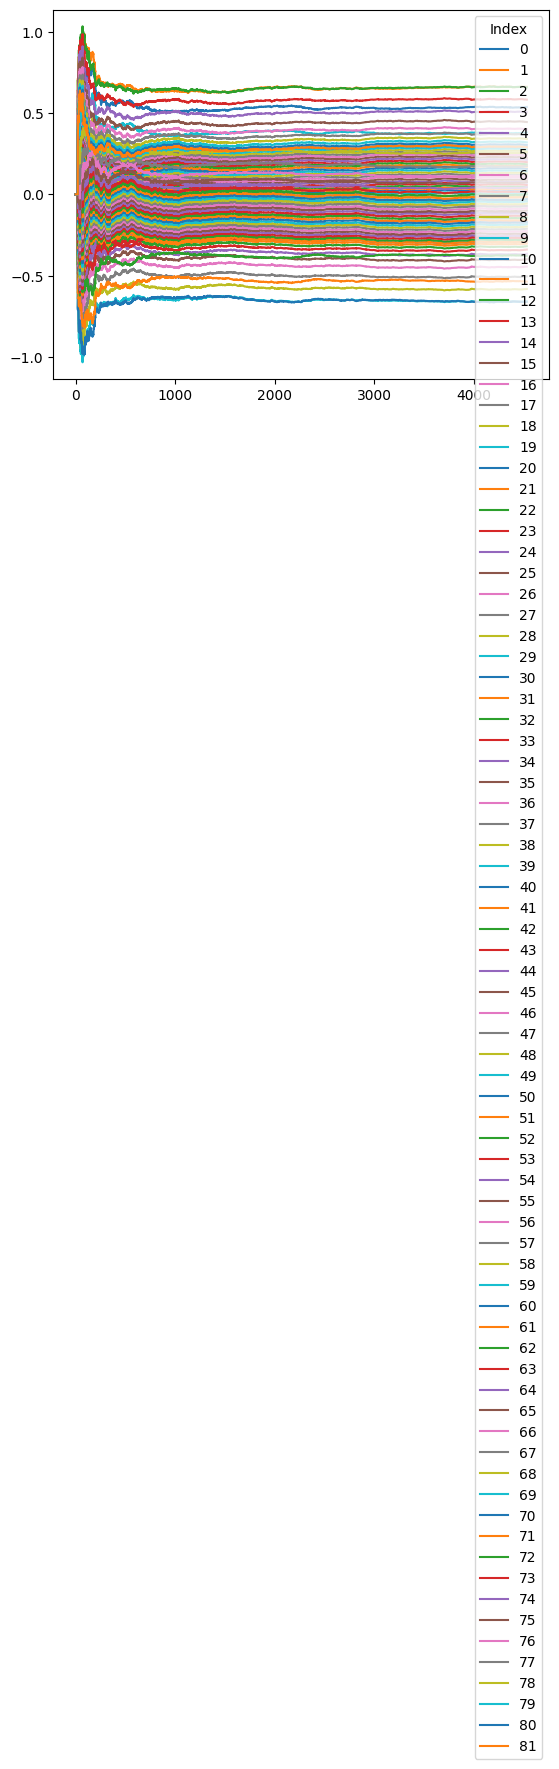

In [94]:
# Plot each sublist if it has a value over 2500
for i, sublist in enumerate(Nested_Rewards):
    plt.plot(sublist, label=str(i))  # Set the legend as the index of the sublist

# Add legend
plt.legend(title="Index")

# Show plot
plt.show()

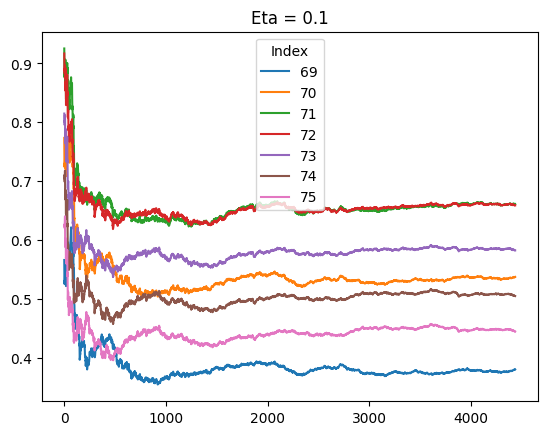

In [98]:


# Plot each sublist if it has a value over 400 or under -400, skipping the first 100 indexes
for i, sublist in enumerate(Nested_Rewards):
    sublist_to_check = sublist[100:]  # Skip the first 100 indexes
    if any(value > 0.6 for value in sublist_to_check) :
        plt.plot(sublist_to_check, label=str(i))  # Set the legend as the index of the sublist

# Add legend
plt.legend(title="Index")
plt.title('Eta = 0.1')
# Show plot
plt.show()


In [101]:
agent.actions[31]

array([0.55])

In [100]:
72%41

31